# Import

# Diabetic Retinopathy Detection using DiabetiCNN

This project implements a Convolutional Neural Network (CNN), named DiabetiCNN, for the detection of Diabetic Retinopathy (DR) from retinal images. The work is based on an existing research paper and utilizes three distinct datasets: DiaretDB0, DiaretDB1, and DrimDB.

## Project Overview:

- **Dataset Preparation**: The notebook includes custom functions to load and preprocess images from the DiaretDB0, DiaretDB1, and DrimDB datasets. Each dataset is split into training and testing sets, and CSV files are generated to manage image paths and labels.
- **Image Preprocessing**: A key aspect of this project is the robust preprocessing pipeline. It involves:
    - **Retina Extraction**: A custom `extract_retina` function is used to segment and isolate the retinal region from the fundus images, optionally using provided binary masks for DiaretDB0 or generating masks automatically.
    - **CLAHE Application**: The `apply_CLAHE` function enhances image contrast, particularly for subtle features, by applying Contrast Limited Adaptive Histogram Equalization (CLAHE) in two stages (for coarse and fine details).
- **Custom Dataset Class**: `DIARETDB0Dataset` and `DIARETDB1_DRIMDB_Dataset` classes are implemented to handle dataset loading, image preprocessing, and transformation, making them ready for PyTorch's DataLoader.
- **Model Architecture**: The `DiabetiCNN` model is a sequential CNN designed with convolutional layers, batch normalization, ReLU activations, and max-pooling layers for feature extraction, followed by an adaptive average pooling layer, flatten, linear layers and softmax for classification.
- **Training and Evaluation**: The model is trained independently on each dataset, and its performance is evaluated using standard metrics such as loss curves, confusion matrices, classification reports, and overall accuracy. The results for each dataset are visualized and printed.

## Technologies Used:

- Python
- PyTorch
- OpenCV
- scikit-learn
- matplotlib
- pandas

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image, ImageOps, ImageEnhance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from skimage import exposure, filters, morphology, measure, feature
from skimage.util import random_noise, img_as_float
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from scipy import ndimage as ndi
import cv2
import random
import xml.etree.ElementTree as ET
import glob

# Dataset : DiaretDB0 (l'auteur semble s'être trompé)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nguyenhung1903/diaretdb1-standard-diabetic-retinopathy-database")

print("Path to dataset files:", path)

100%|██████████| 257M/257M [00:01<00:00, 147MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nguyenhung1903/diaretdb1-standard-diabetic-retinopathy-database/versions/1


In [ ]:
ROOT_DIRECTORY_DIARETDB0 = os.path.join(path, "diaretdb0_v_1_1", "resources")
print(ROOT_DIRECTORY_DIARETDB0)

/root/.cache/kagglehub/datasets/nguyenhung1903/diaretdb1-standard-diabetic-retinopathy-database/versions/1/diaretdb0_v_1_1/resources


## Prétraitement

Création des fichiers train.csv / test.csv

In [ ]:
def create_diaretdb0(root_directory, test_size=0.2, random_state=42):
  fundus_directory = os.path.join(root_directory, "images", "diaretdb0_fundus_images")
  groundtruths_directory = os.path.join(root_directory, "images", "diaretdb0_groundtruths")
  anomalies = [
      'redsmalldots',
      'hemorrhages',
      'hardexudates',
      'softexudates',
      'neovascularisation'
  ]

  data = []
  for img_name in os.listdir(fundus_directory):
    if not img_name.lower().endswith('.png'):
      continue

    img_base = os.path.splitext(img_name)[0]
    img_path_fundus = os.path.join(fundus_directory, img_name)
    img_path_groundtruths = os.path.join(groundtruths_directory, img_base + ".dot")

    label = 0
    if os.path.exists(img_path_groundtruths):
      text = open(img_path_groundtruths).read().lower()
      if any(anomaly in text for anomaly in anomalies):
        label = 1

    data.append({
        'image_path': img_path_fundus,
        'label': label
    })

  df = pd.DataFrame(data)
  train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['label'])

  train_df.to_csv("train_diaretdb0.csv", index=False)
  test_df.to_csv("test_diaretdb0.csv", index=False)

  return train_df, test_df

train_df, test_df = create_diaretdb0(ROOT_DIRECTORY_DIARETDB0)
print(f"train: {len(train_df)}, {train_df['label'].value_counts()}")
print(f"test : {len(test_df)}, {test_df['label'].value_counts()}")

train: 104, label
1    86
0    18
Name: count, dtype: int64
test : 26, label
1    22
0     4
Name: count, dtype: int64


In [ ]:
def extract_retina(img_np_rgb, mask_bool=False, mask_path=None):
  # Utiliser masque existant
  if mask_bool and mask_path and os.path.exists(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Redimensionner
    if mask.shape[:2] != img_np_rgb.shape[:2]:
      mask = cv2.resize(mask, (img_np_rgb.shape[1], img_np_rgb.shape[0]))
      _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

  # Creer masque
  else:
    gray = cv2.cvtColor(img_np_rgb, cv2.COLOR_RGB2GRAY)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    threshold = max(0, np.mean(gray) / 3 - 7)
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    thresh = cv2.medianBlur(thresh, 25)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    if contours:
      largest_contour = max(contours, key=cv2.contourArea)
      cv2.drawContours(mask, [largest_contour], -1, 255, -1)

  # Appliquer masque
  img_masked = cv2.bitwise_and(img_np_rgb, img_np_rgb, mask=mask)

  return img_masked, mask

def apply_CLAHE(img):
  img = img.astype(np.uint8)

  # Convertir en LAB pour CLAHE
  lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
  l, a, b = cv2.split(lab)

  # Premier CLAHE (pour gros details)
  clahe1 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(16, 16))
  l_clahe1 = clahe1.apply(l)

  # Second CLAHE (pour petits details)
  clahe2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  l_clahe2 = clahe2.apply(l_clahe1)

  lab_clahe = cv2.merge([l_clahe2, a, b])
  return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

Création du dataset personnalisé

In [ ]:
class DIARETDB0Dataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.data = pd.read_csv(csv_file)
    self.mask_dir = os.path.join(root_dir, "images", "diaretdb0_binary_masks")
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path = self.data.iloc[idx, 0]
    label = int(self.data.iloc[idx, 1])

    # Charger image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Enlever arriere plan
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    mask_path = os.path.join(self.mask_dir, img_name + "_valid.png")
    use_mask = os.path.exists(mask_path)

    img_mask, _ = extract_retina(img, use_mask, mask_path if use_mask else None)

    # Appliquer CLAHE
    img_clahe = apply_CLAHE(img_mask)

    img_pil = Image.fromarray(img_clahe)

    if self.transform:
      img_tensor = self.transform(img_pil)
    else:
      img_tensor = transforms.ToTensor()(img_pil)

    return img_tensor, label

Fonctuon de visualisation du prétraitement

In [ ]:
def visualize_image(csv_path, mask_dir=None, samples=3, random_state=42):
  # Charger donnees
  data = pd.read_csv(csv_path)
  samples = min(samples, len(data))
  data_sample = data.sample(n=samples, random_state=random_state)

  fig, axes = plt.subplots(samples, 4, figsize=(20, samples * 5))
  for i, row in enumerate(data_sample.itertuples()):
    img_path = row.image_path

    # Charger image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Enlever arriere plan
    img_name = os.path.splitext(os.path.basename(img_path))[0]

    if mask_dir:
      mask_path = os.path.join(mask_dir, img_name + "_valid.png")
      use_mask = os.path.exists(mask_path)
    else:
      mask_path = None
      use_mask = False

    img_mask, mask = extract_retina(img, use_mask, mask_path if use_mask else None)

    # Appliquer CLAHE
    img_clahe = apply_CLAHE(img_mask)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"{os.path.basename(img_path)}\n 1 Originale")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title("2 Masque")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(img_mask)
    axes[i, 2].set_title("3 Après extract_retina")
    axes[i, 2].axis('off')

    axes[i, 3].imshow(img_clahe)
    axes[i, 3].set_title("4 Après apply_CLAHE")
    axes[i, 3].axis('off')

  plt.tight_layout()
  plt.show()

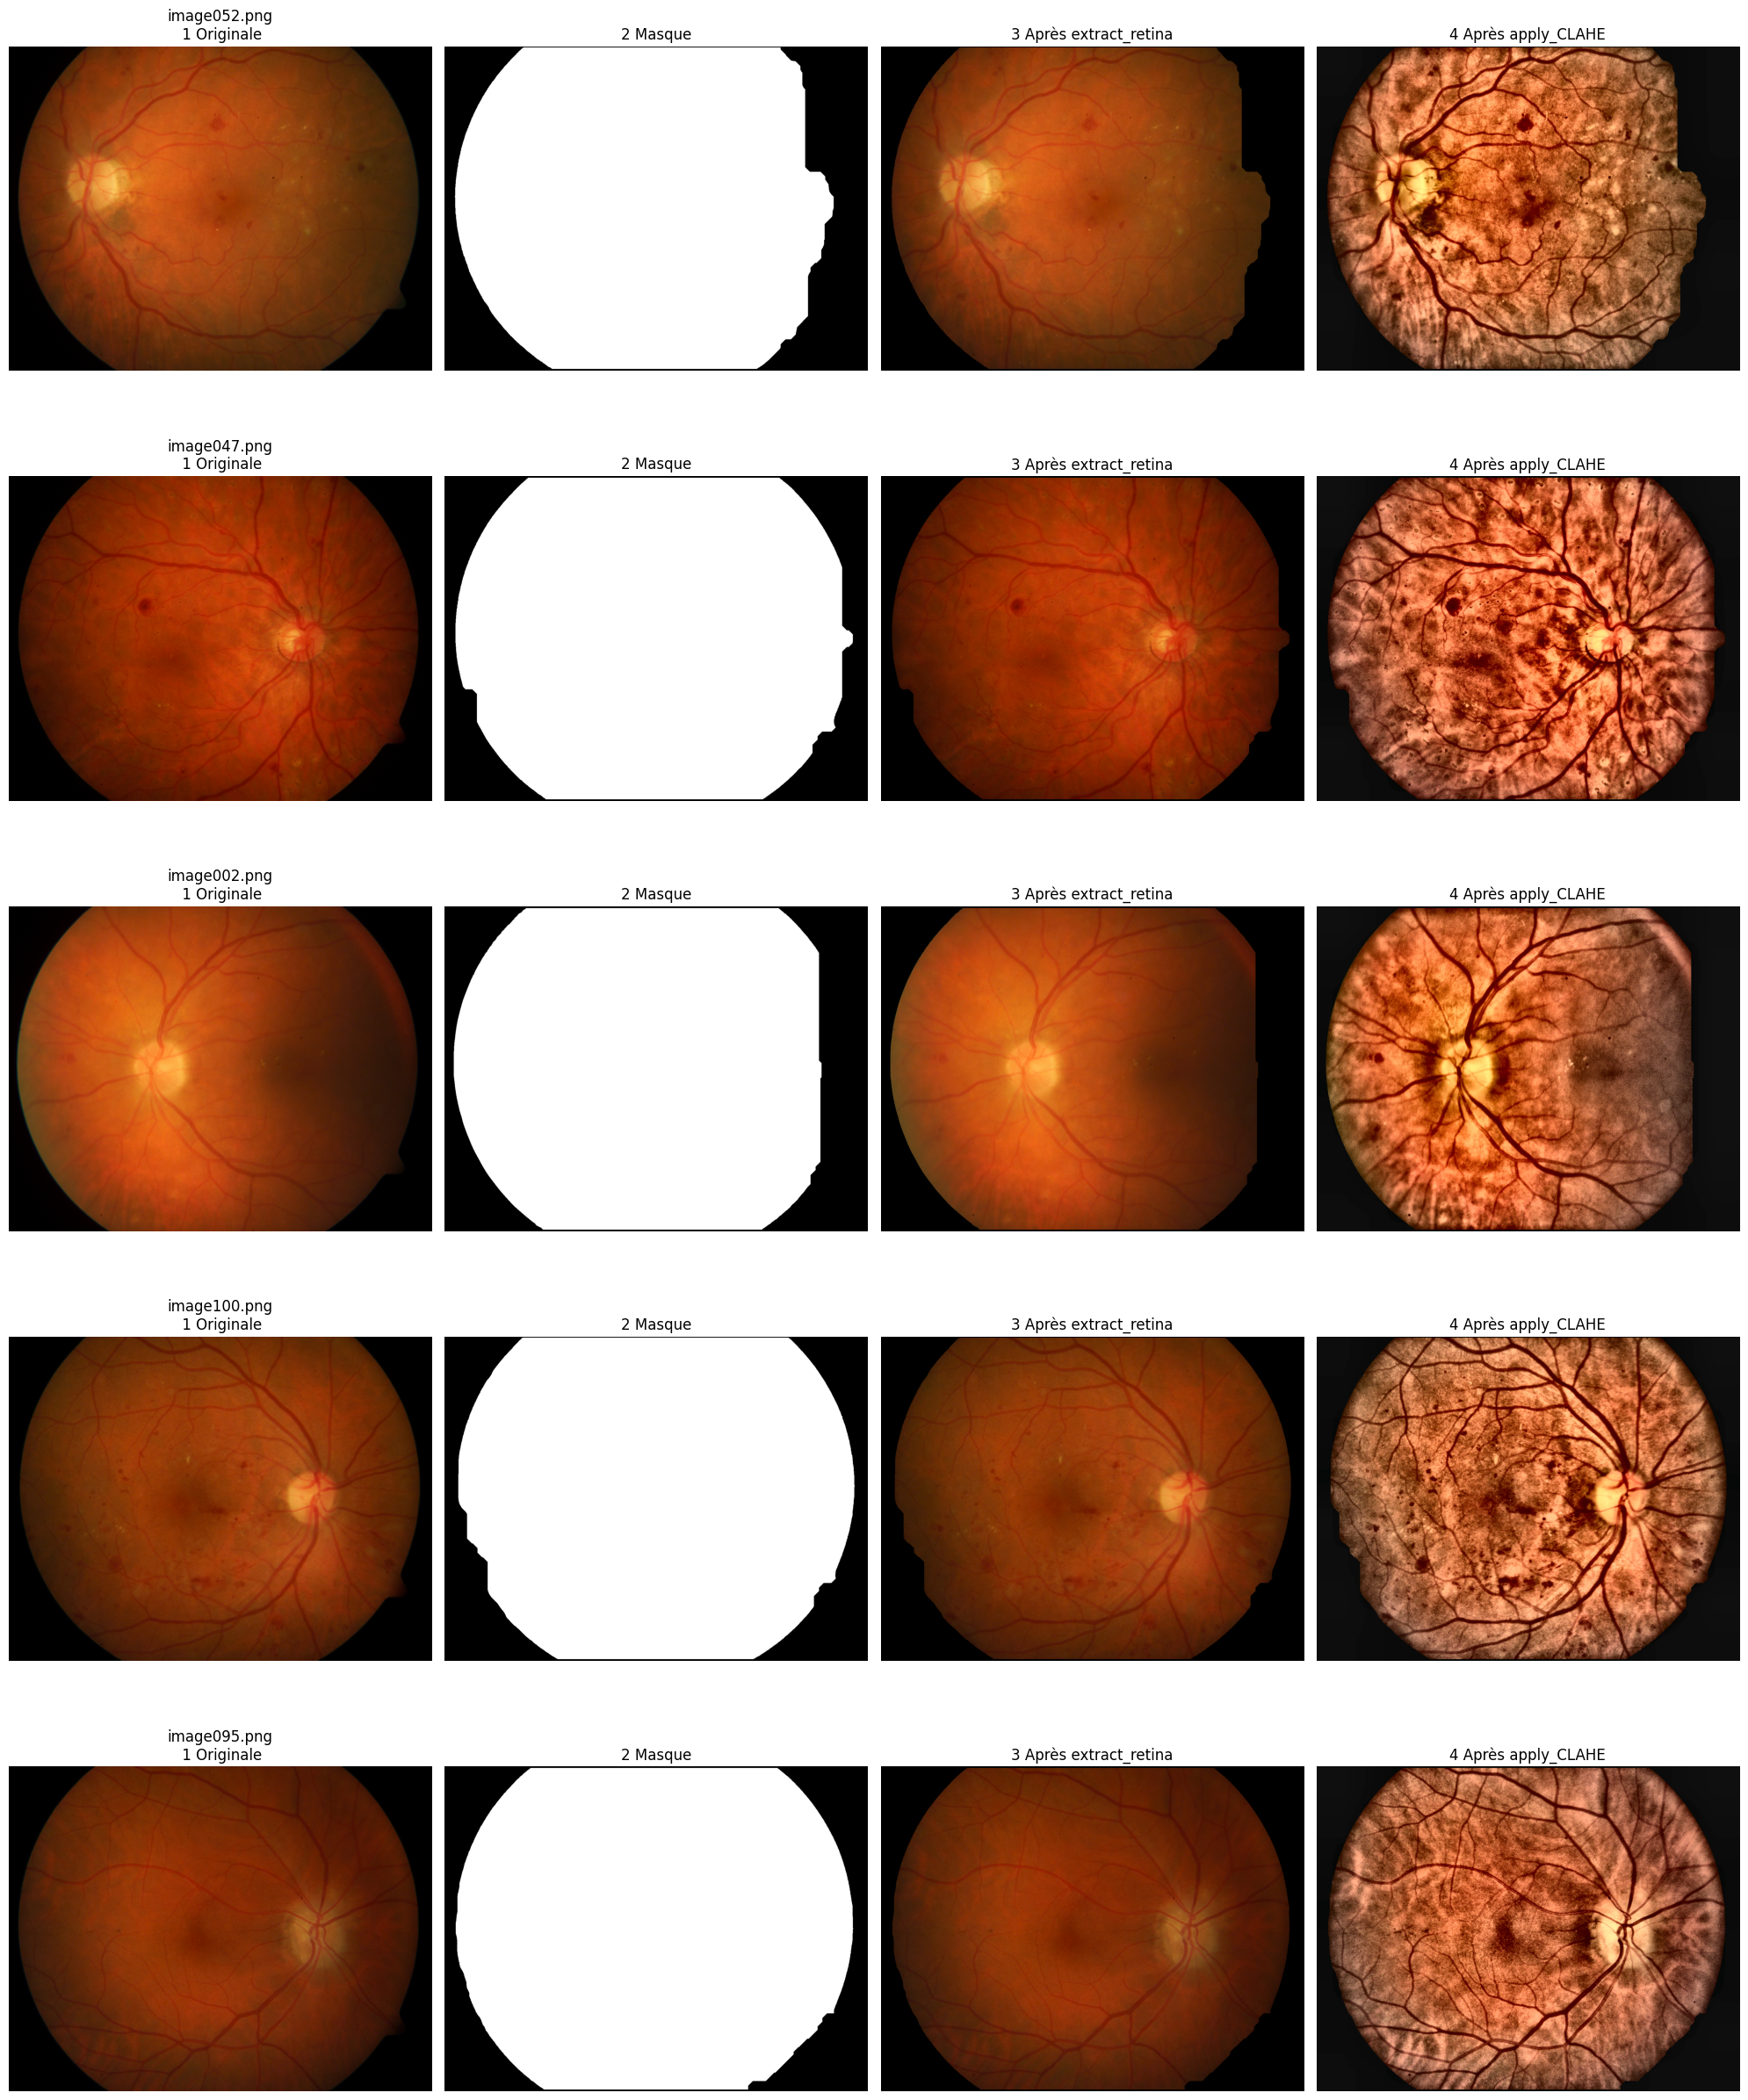

In [ ]:
MASK_DIRECTORY = os.path.join(ROOT_DIRECTORY_DIARETDB0, "images", "diaretdb0_binary_masks")
visualize_image("train_diaretdb0.csv", MASK_DIRECTORY, samples=5)

# Dataset : DiaretDB1 (l'auteur semble s'être trompé)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nguyenhung1903/diaretdb1-v21")

print("Path to dataset files:", path)

100%|██████████| 138M/138M [00:01<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nguyenhung1903/diaretdb1-v21/versions/1


In [ ]:
ROOT_DIRECTORY_DIARETDB1 = os.path.join(path, "ddb1_v02_01")
print(ROOT_DIRECTORY_DIARETDB1)

/root/.cache/kagglehub/datasets/nguyenhung1903/diaretdb1-v21/versions/1/ddb1_v02_01


Les anomalies de l’œil se trouvent dans les fichiers XML du dataset.
Elles sont indiquées dans les markingType.

Dans le dataset, il y a au total 8 types de markingType, dont deux ne correspondent pas à des anomalies mais à des annotations :
- Disc (annotation)
- Fundus_area (annotation)
- Haemorrhages
- Hard_exudates
- IRMA
- Neovascularisation
- Red_small_dots
- Soft_exudates





In [ ]:
def create_diaretdb1(root_directory, test_size=0.2, random_state=42):
  fundus_directory = os.path.join(root_directory, "images")
  groundtruth_directory = os.path.join(root_directory, "groundtruth")
  lesions = [
      'Haemorrhages',
      'Hard_exudates',
      'Soft_exudates',
      'IRMA',
      'Neovascularisation',
      'Red_small_dots'
  ]

  data = []
  for img_name in os.listdir(fundus_directory):
    if not img_name.lower().endswith('.png'):
      continue

    img_base = os.path.splitext(img_name)[0]
    img_path_fundus = os.path.join(fundus_directory, img_name)
    xml_files = glob.glob(os.path.join(groundtruth_directory, img_base + "*.xml"))

    label = 0
    for xml_path in xml_files:
      pathe = ET.parse(xml_path)
      mark = [m.text.strip() for m in pathe.findall(".//marking/markingtype")]
      if any(lesion in mark for lesion in lesions):
        label = 1
        break

    data.append({
        'image_path': img_path_fundus,
        'label': label
    })

  df = pd.DataFrame(data)
  train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['label'])

  train_df.to_csv("train_diaretdb1.csv", index=False)
  test_df.to_csv("test_diaretdb1.csv", index=False)

  return train_df, test_df

train_df, test_df = create_diaretdb1(ROOT_DIRECTORY_DIARETDB1)
print(f"train: {len(train_df)}, {train_df['label'].value_counts()}")
print(f"test : {len(test_df)}, {test_df['label'].value_counts()}")


train: 71, label
1    67
0     4
Name: count, dtype: int64
test : 18, label
1    17
0     1
Name: count, dtype: int64


Création du dataset personnalisé

In [ ]:
class DIARETDB1_DRIMDB_Dataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.data = pd.read_csv(csv_file)
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path = self.data.iloc[idx, 0]
    label = int(self.data.iloc[idx, 1])

    # Charger image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Enlever arriere plan
    img_mask, _ = extract_retina(img, False)

    # Appliquer CLAHE
    img_clahe = apply_CLAHE(img_mask)

    img_pil = Image.fromarray(img_clahe)

    if self.transform:
      img_tensor = self.transform(img_pil)
    else:
      img_tensor = transforms.ToTensor()(img_pil)

    return img_tensor, label

Visualisation du prétraitement

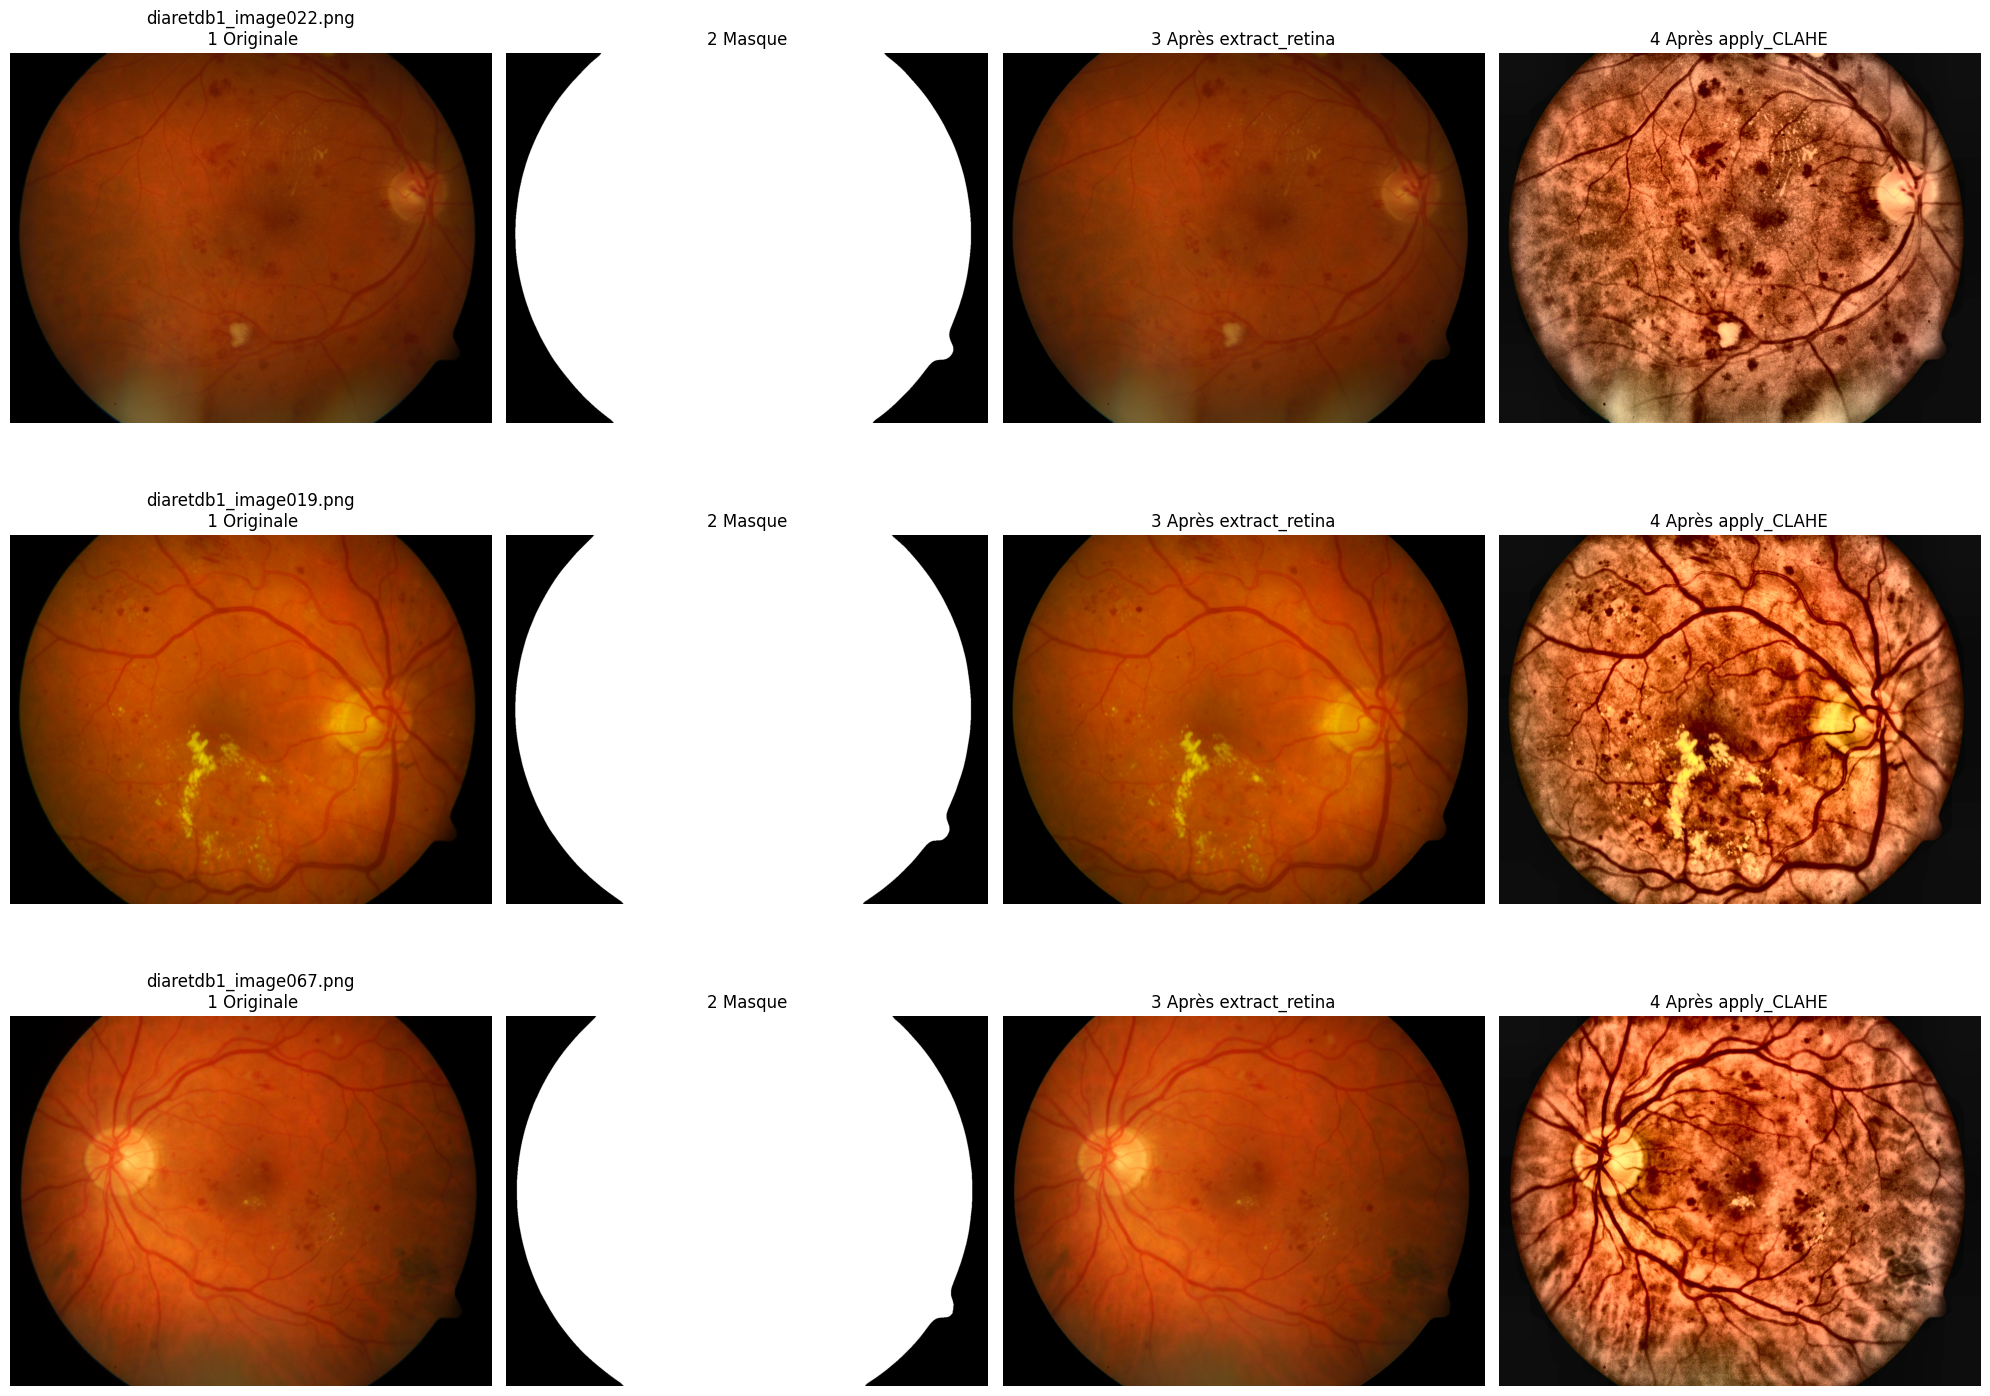

In [ ]:
visualize_image("train_diaretdb1.csv", samples=3)

# Dataset : DrimDB

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subhajournal/drimdb-diabetic-retinopathy-images-database")

print("Path to dataset files:", path)

100%|██████████| 16.4M/16.4M [00:00<00:00, 134MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/subhajournal/drimdb-diabetic-retinopathy-images-database/versions/1


In [ ]:
ROOT_DIRECTORY_DRIMDB = os.path.join(path, "DRIMDB")
print(ROOT_DIRECTORY_DRIMDB)

/root/.cache/kagglehub/datasets/subhajournal/drimdb-diabetic-retinopathy-images-database/versions/1/DRIMDB


In [ ]:
def create_drimdb(root_directory, test_size=0.2, random_state=42):
  good_directory = os.path.join(root_directory, "Good")
  bad_directory = os.path.join(root_directory, "Bad")

  data = []

  for img_name in os.listdir(good_directory):
    if not img_name.lower().endswith(('.jpg')):
      continue

    img_good = os.path.join(good_directory, img_name)
    data.append({
        'image_path': img_good,
        'label': 0
    })

  for img_name in os.listdir(bad_directory):
    if not img_name.lower().endswith(('.jpg')):
      continue

    img_bad = os.path.join(bad_directory, img_name)
    data.append({
        'image_path': img_bad,
        'label': 1
    })

  df = pd.DataFrame(data)
  train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['label'])

  train_df.to_csv("train_drimdb.csv", index=False)
  test_df.to_csv("test_drimdb.csv", index=False)

  return train_df, test_df


train_df, test_df = create_drimdb(ROOT_DIRECTORY_DRIMDB)
print(f"train: {len(train_df)}, {train_df['label'].value_counts()}")
print(f"test : {len(test_df)}, {test_df['label'].value_counts()}")


train: 155, label
0    100
1     55
Name: count, dtype: int64
test : 39, label
0    25
1    14
Name: count, dtype: int64


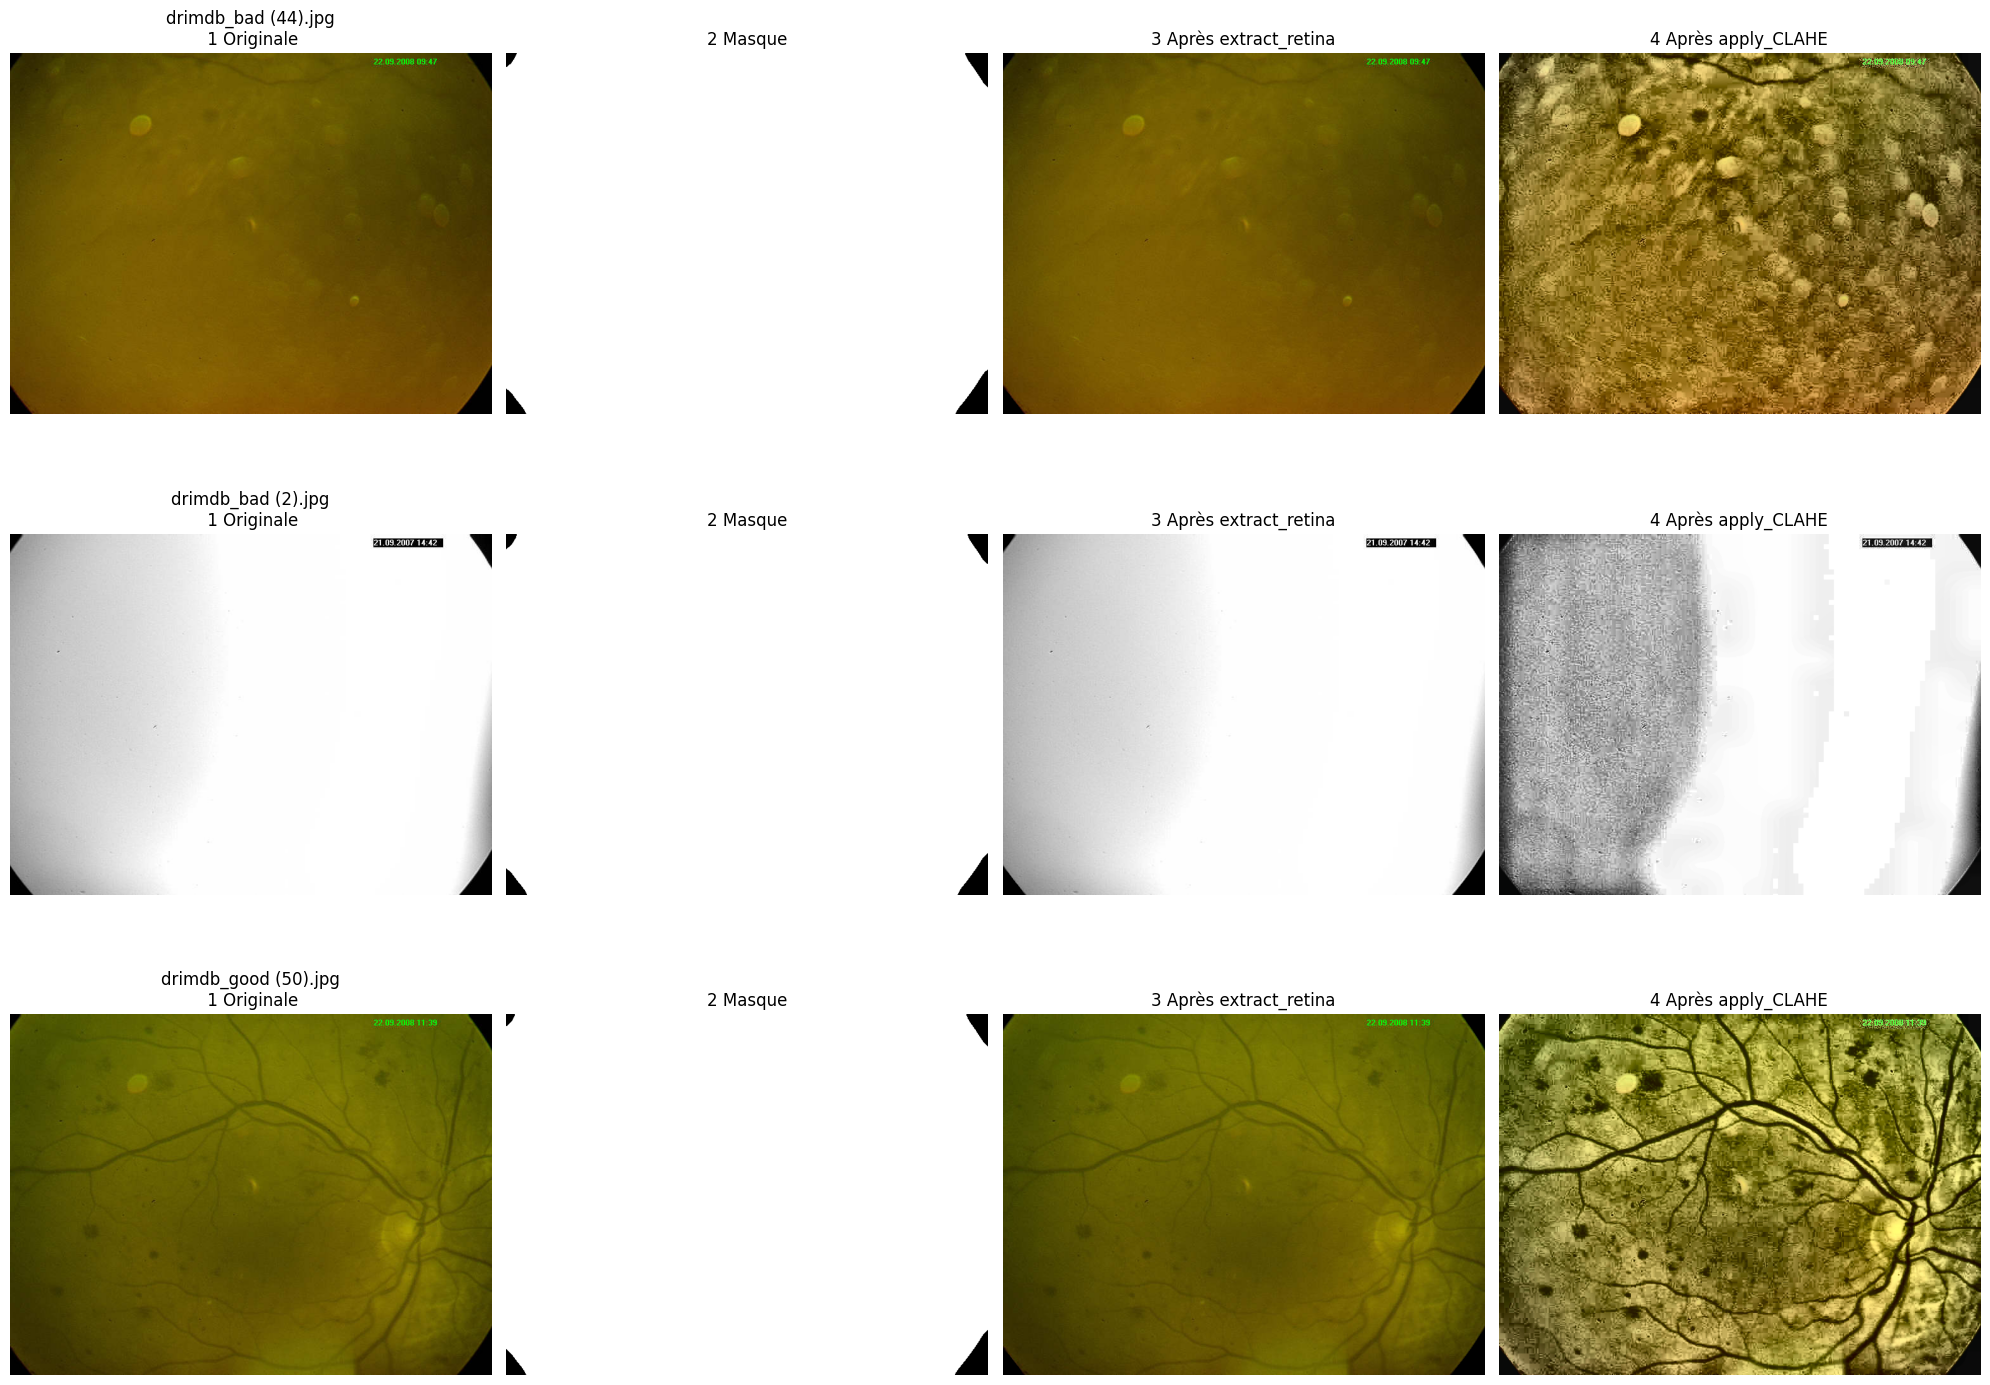

In [ ]:
visualize_image("train_drimdb.csv", samples=3)

# Model architecture
Nous allons implémenter le réseau de neuronne que l'auteur de l'article a détaillé.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class DiabetiCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.features= nn.Sequential(
      nn.Conv2d(3,8, kernel_size=3, stride=1),
      nn.BatchNorm2d(8,eps=1e-5),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

      nn.Conv2d(8,16, kernel_size=3, stride=1),
      nn.BatchNorm2d(16,eps=1e-5),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

      nn.Conv2d(16,32, kernel_size=3, stride=1),
      nn.BatchNorm2d(32,eps=1e-5),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    )

    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(32, 2),
        nn.Dropout(p=0.3),
        nn.Linear(2, 2),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x


## Graphique

In [ ]:
def tracer_graphique(X, Y, titre="Metrique", xlabel="Index de l'image",ylabel="Valeur"):
  plt.figure()
  plt.plot(X, Y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(titre)
  plt.grid(True)
  plt.show()

# Training

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

# DiaretDB0
train_dataset_diaretdb0 = DIARETDB0Dataset("train_diaretdb0.csv", ROOT_DIRECTORY_DIARETDB0, transform=transform)
test_dataset_diaretdb0 = DIARETDB0Dataset("test_diaretdb0.csv", ROOT_DIRECTORY_DIARETDB0, transform=transform)
train_loader_diaretdb0 = DataLoader(train_dataset_diaretdb0, batch_size=16, shuffle=True)
test_loader_diaretdb0 = DataLoader(test_dataset_diaretdb0, batch_size=16, shuffle=True)

# DiaretDB1
train_dataset_diaretdb1 = DIARETDB1_DRIMDB_Dataset("train_diaretdb1.csv", ROOT_DIRECTORY_DIARETDB1, transform=transform)
test_dataset_diaretdb1 = DIARETDB1_DRIMDB_Dataset("test_diaretdb1.csv", ROOT_DIRECTORY_DIARETDB1, transform=transform)
train_loader_diaretdb1 = DataLoader(train_dataset_diaretdb1, batch_size=16, shuffle=True)
test_loader_diaretdb1 = DataLoader(test_dataset_diaretdb1, batch_size=16, shuffle=True)

#DrimDB
train_dataset_drimdb = DIARETDB1_DRIMDB_Dataset("train_drimdb.csv", ROOT_DIRECTORY_DRIMDB, transform=transform)
test_dataset_drimdb = DIARETDB1_DRIMDB_Dataset("test_drimdb.csv", ROOT_DIRECTORY_DRIMDB, transform=transform)
train_loader_drimdb = DataLoader(train_dataset_drimdb, batch_size=16, shuffle=True)
test_loader_drimdb = DataLoader(test_dataset_drimdb, batch_size=16, shuffle=True)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def training(model, train_dataloader, lr=0.001, epochs=20):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    batch_losses = []
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0 # permet d'accumuler les pertes batch par batch
        correct = 0
        total = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
    return batch_losses, epoch_losses

# Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def evaluation(model, test_dataloader):
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy()) # CPU obligatoire pour utiliser Scikit-learn
            all_labels.extend(labels.cpu().numpy())

    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "DR"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Matrice de confusion - Test set")
    plt.show()

    # Rapport de classification
    print(classification_report(all_labels, all_preds, target_names=["Normal", "DR"]))

    # Accuracy globale
    acc = (cm.trace() / cm.sum()) * 100
    print(f"Accuracy globale : {acc:.2f}%")

    return acc, cm

# Application

Epoch [1/20] | Loss: 0.6647 | Acc: 0.7788
Epoch [2/20] | Loss: 0.6350 | Acc: 0.8269
Epoch [3/20] | Loss: 0.6161 | Acc: 0.8173
Epoch [4/20] | Loss: 0.6043 | Acc: 0.8269
Epoch [5/20] | Loss: 0.5835 | Acc: 0.8269
Epoch [6/20] | Loss: 0.5744 | Acc: 0.8269
Epoch [7/20] | Loss: 0.5668 | Acc: 0.8269
Epoch [8/20] | Loss: 0.5586 | Acc: 0.8269
Epoch [9/20] | Loss: 0.5508 | Acc: 0.8269
Epoch [10/20] | Loss: 0.5442 | Acc: 0.8269
Epoch [11/20] | Loss: 0.5291 | Acc: 0.8269
Epoch [12/20] | Loss: 0.5187 | Acc: 0.8269
Epoch [13/20] | Loss: 0.5144 | Acc: 0.8269
Epoch [14/20] | Loss: 0.5233 | Acc: 0.8269
Epoch [15/20] | Loss: 0.5340 | Acc: 0.8269
Epoch [16/20] | Loss: 0.5275 | Acc: 0.8269
Epoch [17/20] | Loss: 0.5051 | Acc: 0.8269
Epoch [18/20] | Loss: 0.5118 | Acc: 0.8269
Epoch [19/20] | Loss: 0.5149 | Acc: 0.8269
Epoch [20/20] | Loss: 0.5090 | Acc: 0.8269


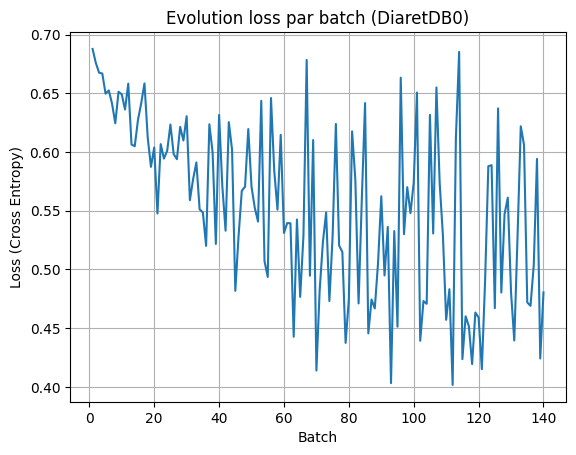

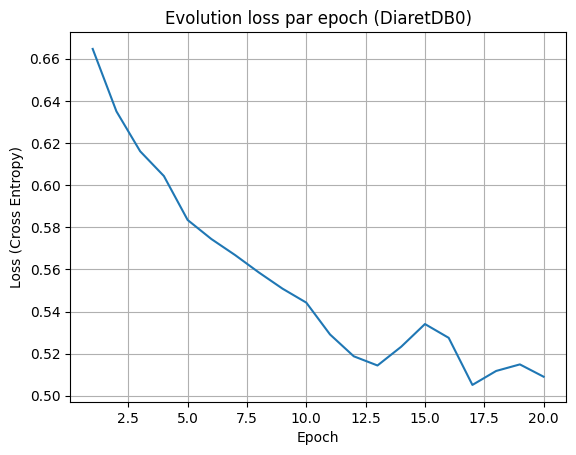

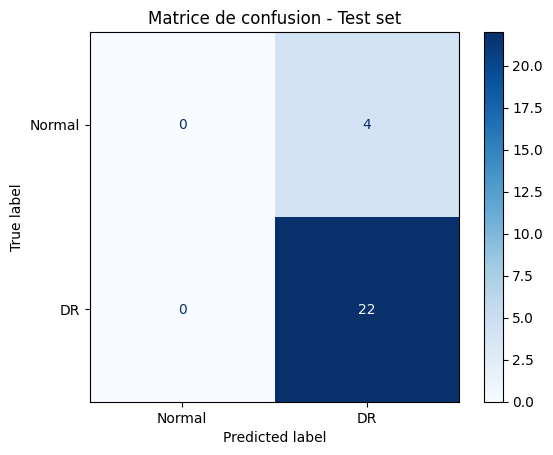

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         4
          DR       0.85      1.00      0.92        22

    accuracy                           0.85        26
   macro avg       0.42      0.50      0.46        26
weighted avg       0.72      0.85      0.78        26

Accuracy globale : 84.62%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(np.float64(84.61538461538461),
 array([[ 0,  4],
        [ 0, 22]]))

In [ ]:
modelDiaretDB0 = DiabetiCNN()
batch_losses, epoch_losses = training(modelDiaretDB0, train_loader_diaretdb0)
tracer_graphique(range(1, len(batch_losses)+1), batch_losses, titre="Evolution loss par batch (DiaretDB0)", ylabel="Loss (Cross Entropy)", xlabel="Batch")
tracer_graphique(range(1, len(epoch_losses)+1), epoch_losses, titre="Evolution loss par epoch (DiaretDB0)", ylabel="Loss (Cross Entropy)", xlabel="Epoch")
evaluation(modelDiaretDB0, test_loader_diaretdb0)

Epoch [1/20] | Loss: 0.5097 | Acc: 0.9437
Epoch [2/20] | Loss: 0.5035 | Acc: 0.9437
Epoch [3/20] | Loss: 0.4938 | Acc: 0.9437
Epoch [4/20] | Loss: 0.4866 | Acc: 0.9437
Epoch [5/20] | Loss: 0.4818 | Acc: 0.9437
Epoch [6/20] | Loss: 0.4679 | Acc: 0.9437
Epoch [7/20] | Loss: 0.4617 | Acc: 0.9437
Epoch [8/20] | Loss: 0.4618 | Acc: 0.9437
Epoch [9/20] | Loss: 0.4510 | Acc: 0.9437
Epoch [10/20] | Loss: 0.4424 | Acc: 0.9437
Epoch [11/20] | Loss: 0.4323 | Acc: 0.9437
Epoch [12/20] | Loss: 0.4233 | Acc: 0.9437
Epoch [13/20] | Loss: 0.4168 | Acc: 0.9437
Epoch [14/20] | Loss: 0.4191 | Acc: 0.9437
Epoch [15/20] | Loss: 0.4160 | Acc: 0.9437
Epoch [16/20] | Loss: 0.4003 | Acc: 0.9437
Epoch [17/20] | Loss: 0.4070 | Acc: 0.9437
Epoch [18/20] | Loss: 0.4092 | Acc: 0.9437
Epoch [19/20] | Loss: 0.3954 | Acc: 0.9437
Epoch [20/20] | Loss: 0.4016 | Acc: 0.9437


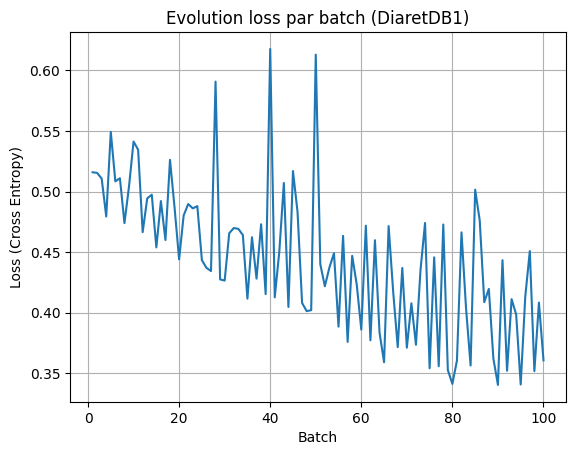

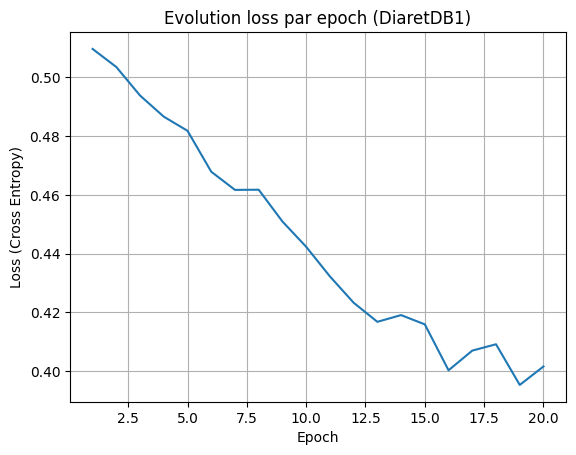

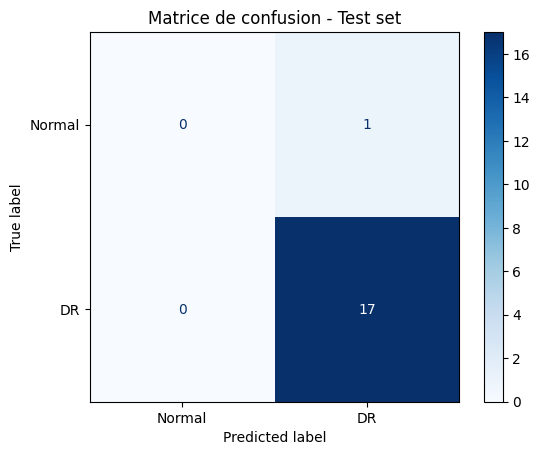

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         1
          DR       0.94      1.00      0.97        17

    accuracy                           0.94        18
   macro avg       0.47      0.50      0.49        18
weighted avg       0.89      0.94      0.92        18

Accuracy globale : 94.44%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(np.float64(94.44444444444444),
 array([[ 0,  1],
        [ 0, 17]]))

In [ ]:
modelDiaretDB1 = DiabetiCNN()
batch_losses, epoch_losses = training(modelDiaretDB1, train_loader_diaretdb1)
tracer_graphique(range(1, len(batch_losses)+1), batch_losses, titre="Evolution loss par batch (DiaretDB1)", ylabel="Loss (Cross Entropy)", xlabel="Batch")
tracer_graphique(range(1, len(epoch_losses)+1), epoch_losses, titre="Evolution loss par epoch (DiaretDB1)", ylabel="Loss (Cross Entropy)", xlabel="Epoch")
evaluation(modelDiaretDB1, test_loader_diaretdb1)

Epoch [1/20] | Loss: 0.5852 | Acc: 0.7935
Epoch [2/20] | Loss: 0.5098 | Acc: 0.8323
Epoch [3/20] | Loss: 0.4740 | Acc: 0.8839
Epoch [4/20] | Loss: 0.4490 | Acc: 0.9032
Epoch [5/20] | Loss: 0.4257 | Acc: 0.9548
Epoch [6/20] | Loss: 0.4414 | Acc: 0.9161
Epoch [7/20] | Loss: 0.4196 | Acc: 0.9226
Epoch [8/20] | Loss: 0.4134 | Acc: 0.9290
Epoch [9/20] | Loss: 0.3894 | Acc: 0.9548
Epoch [10/20] | Loss: 0.3894 | Acc: 0.9548
Epoch [11/20] | Loss: 0.3970 | Acc: 0.9484
Epoch [12/20] | Loss: 0.3841 | Acc: 0.9548
Epoch [13/20] | Loss: 0.3855 | Acc: 0.9484
Epoch [14/20] | Loss: 0.3895 | Acc: 0.9548
Epoch [15/20] | Loss: 0.3820 | Acc: 0.9484
Epoch [16/20] | Loss: 0.3916 | Acc: 0.9484
Epoch [17/20] | Loss: 0.3753 | Acc: 0.9548
Epoch [18/20] | Loss: 0.3751 | Acc: 0.9742
Epoch [19/20] | Loss: 0.3771 | Acc: 0.9613
Epoch [20/20] | Loss: 0.3714 | Acc: 0.9613


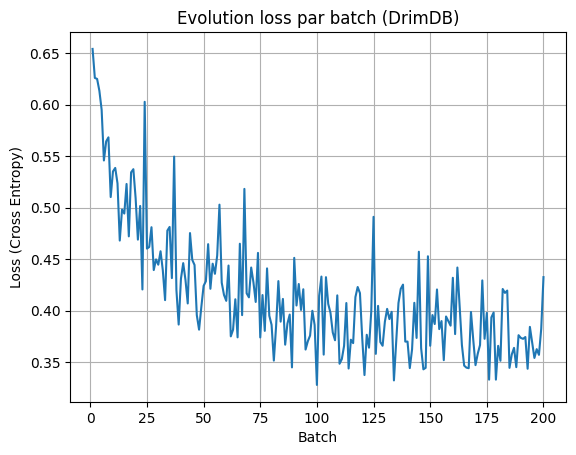

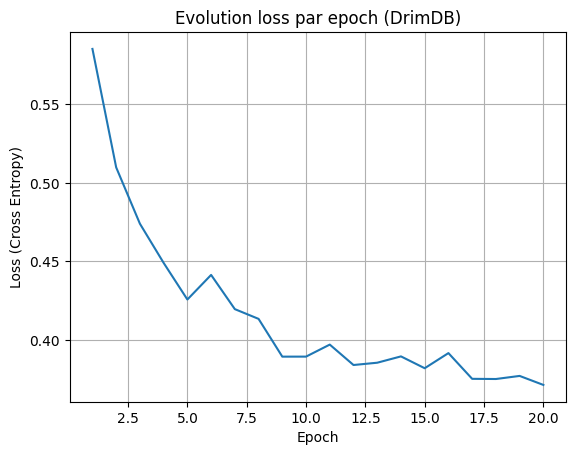

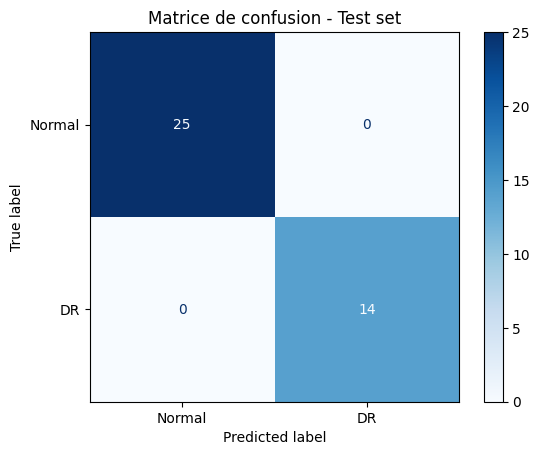

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        25
          DR       1.00      1.00      1.00        14

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

Accuracy globale : 100.00%


(np.float64(100.0),
 array([[25,  0],
        [ 0, 14]]))

In [ ]:
modelDrim = DiabetiCNN()
batch_losses, epoch_losses = training(modelDrim, train_loader_drimdb)
tracer_graphique(range(1, len(batch_losses)+1), batch_losses, titre="Evolution loss par batch (DrimDB)", ylabel="Loss (Cross Entropy)", xlabel="Batch")
tracer_graphique(range(1, len(epoch_losses)+1), epoch_losses, titre="Evolution loss par epoch (DrimDB)", ylabel="Loss (Cross Entropy)", xlabel="Epoch")
evaluation(modelDrim, test_loader_drimdb)